In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [2]:


base = VGG16(
    weights="vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False,
    input_shape=(64,64,3)
)


In [3]:

# ---- Freeze base model ----
for layer in base.layers:
    layer.trainable = False


In [4]:
train_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [5]:


train_data = train_gen.flow_from_directory(
    "caltech-101-img", target_size=(64,64),
    batch_size=32, subset='training'
)

val_data = train_gen.flow_from_directory(
    "caltech-101-img", target_size=(64,64),
    batch_size=32, subset='validation'
)


Found 7357 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


In [6]:

# ---- Add Classifier on top of base model ----
model = Sequential([
    base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(102, activation='softmax')
])

# ---- Compile (train only new layers) ----
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [7]:

# ---- Train ----
model.fit(train_data, validation_data=val_data, epochs=5)


Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.3443 - loss: 3.0440 - val_accuracy: 0.5246 - val_loss: 2.1517
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 60s 261ms/step - accuracy: 0.5020 - loss: 2.0636 - val_accuracy: 0.6023 - val_loss: 1.6792
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 235ms/step - accuracy: 0.5849 - loss: 1.6459 - val_accuracy: 0.6381 - val_loss: 1.4894
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 54s 233ms/step - accuracy: 0.6397 - loss: 1.3968 - val_accuracy: 0.6504 - val_loss: 1.4182
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 58s 253ms/step - accuracy: 0.6807 - loss: 1.2195 - val_accuracy: 0.6655 - val_loss: 1.3337


In [8]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.6655 - loss: 1.3337
Validation Loss: 1.3337
Validation Accuracy: 0.6655


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


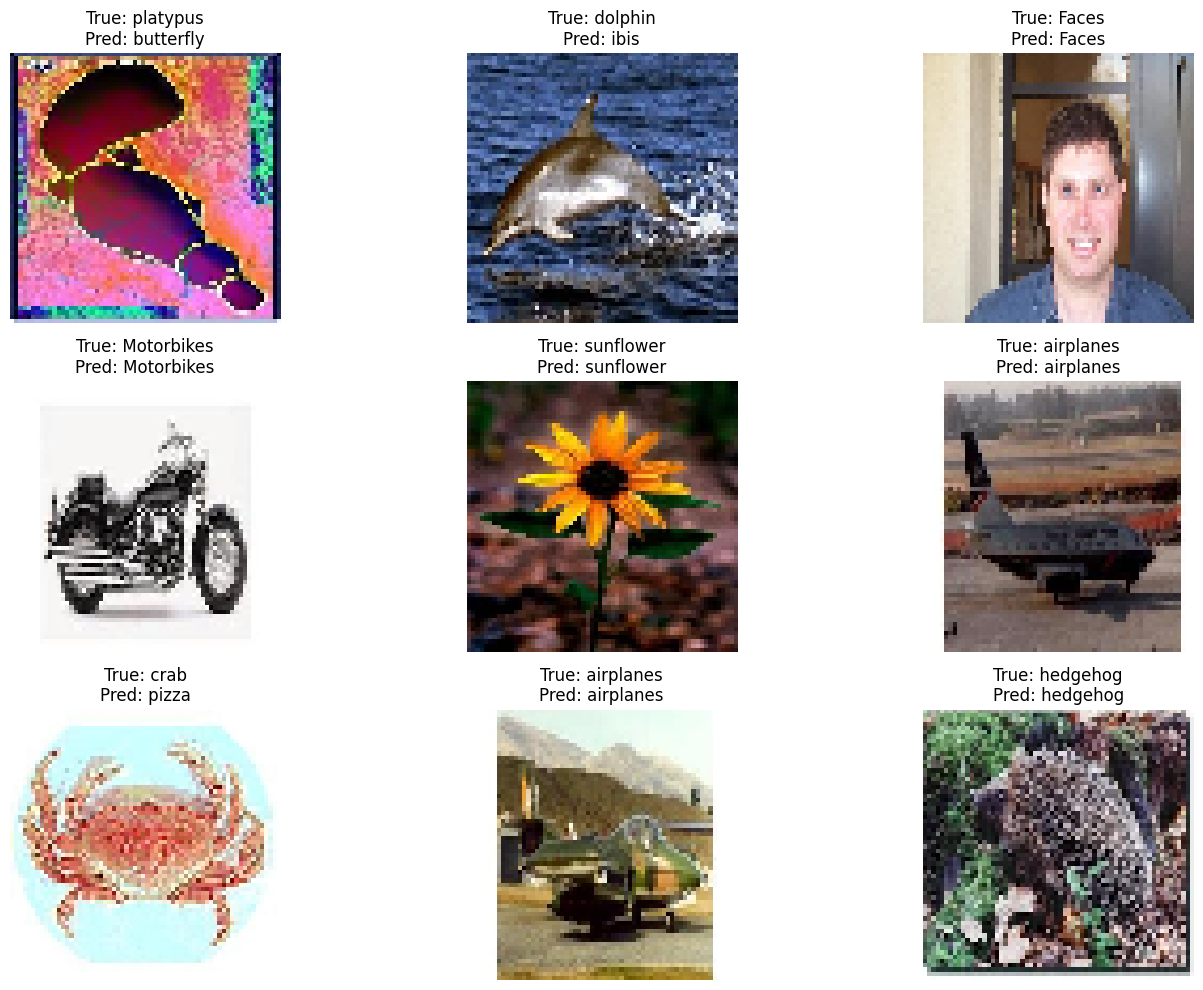


Batch Accuracy: 21/32 = 65.62%


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of validation images
images, labels = next(val_data)

# Make predictions
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

class_names = list(val_data.class_indices.keys())

# Display some samples with predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print accuracy for this batch
correct = np.sum(predicted_classes == true_classes)
print(f"\nBatch Accuracy: {correct}/{len(images)} = {correct/len(images)*100:.2f}%")

In [10]:
# ------------------------------
# e) Fine-tune (optional) — unfreeze few deeper conv layers
# ------------------------------
for layer in base.layers[-4:]:   #a unfreeze last 4 conv blocks
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-5),
              metrics=['accuracy'])

history2 = model.fit(train_data,
                     validation_data=val_data,
                     epochs=5)

Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 279ms/step - accuracy: 0.7415 - loss: 0.9402 - val_accuracy: 0.6985 - val_loss: 1.2263
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 64s 276ms/step - accuracy: 0.7824 - loss: 0.7869 - val_accuracy: 0.7030 - val_loss: 1.1879
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 64s 279ms/step - accuracy: 0.8041 - loss: 0.6942 - val_accuracy: 0.7148 - val_loss: 1.1629
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 64s 280ms/step - accuracy: 0.8160 - loss: 0.6275 - val_accuracy: 0.7170 - val_loss: 1.1674
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 67s 293ms/step - accuracy: 0.8419 - loss: 0.5684 - val_accuracy: 0.7226 - val_loss: 1.1467
